In [1]:
import pandas as pd
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import numpy as np
import random
import math  # 导入数学运算库
from sklearn.preprocessing import MinMaxScaler

## 读取数据集

In [2]:
data = pd.read_csv("C:/Users/Administrator/Desktop/毕设/旅游景点数据集/数据集.csv", encoding='gbk')

In [3]:
#预览数据集前10行
data.head(10)

,编号,城市,名称,星级,评分,价格,销量,省/市/区,坐标,简介,是否免费,具体地址
0,0,上海,上海迪士尼乐园,NaN,0,325,19459,上海·上海·浦东新区,"121.667917,31.149712",每个女孩都有一场迪士尼梦,False,上海市浦东新区川沙镇黄赵路310号上海迪士尼乐园
1,1,上海,上海海昌海洋公园,4 A,0,276.5,19406,上海·上海·浦东新区,"121.915647,30.917713",看珍稀海洋生物 | 玩超刺激娱乐项目,False,上海市浦东新区南汇城银飞路166号
2,2,上海,上海野生动物园,5 A,3.6,116,6764,上海·上海·浦东新区,"121.728112,31.059636",全球动物聚集地 | 零距离和动物做朋友,False,上海市浦东新区南六公路178号
3,3,上海,东方绿舟,4 A,3.5,40,5353,上海·上海·青浦区,"121.015977,31.107866",全国首屈一指的青少年校外教育营地,False,上海市青浦区沪青平公路6888号
4,4,上海,东方明珠,5 A,3.8,54,3966,上海·上海·浦东新区,"121.50626,31.245369",感受云端漫步，品味老上海风情,False,上海市浦东新区世纪大道1号
5,5,上海,上海自然博物馆,NaN,3.5,32.4,3237,上海·上海·静安区,"121.469083,31.241294",在这里领略物种的变迁,False,上海市静安区石门二路128号静安雕塑公园内
6,6,上海,上海佛罗伦萨小镇,3A,0,6.6,2682,上海·上海·浦东新区,"121.770767,31.202718",2015年1月开业，落户上海浦东，成为上海及周边江浙地区时尚爱好者的钟爱去处。上海佛罗伦萨小...,False,上海市浦东新区卓耀路58弄 （近地铁2号线远东大道站）
7,7,上海,上海科技馆,5 A,3.7,45,2120,上海·上海·浦东新区,"121.54785,31.224219",魔都科普教育殿堂 | 周末遛娃圣地,False,上海市浦东新区世纪大道2000号(近二号线上海科技馆站)
8,8,上海,豫园,4 A,4.2,40,2103,上海·上海·黄浦区,"121.498971,31.233463",“奇秀甲于东南”、“东南名园冠”。,False,上海市黄浦区福佑路168号
9,9,上海,上海动物园,4 A,3.6,39.6,1718,上海·上海·长宁区,"121.369411,31.199264",大型城市动物园 | 620余种可爱动物,False,上海市长宁区虹桥路2381号


In [4]:
#data.info #获取关于 DataFrame 的简要信息摘要

## 数据清洗和预处理

## 删除异常值

In [5]:
# 创建布尔条件，检查特征'坐标'是否为'0.0,0.0'
condition = (data['坐标'] != '0.0,0.0')
# 根据布尔条件筛选数据集，保留不含异常特征值的样本
data = data[condition]

## 清洗非法字符

In [6]:
# 清洗评分、价格和销量特征中的非数值型字符串数据，并将异常值设置为缺失值
def clean_numeric_data(df, columns):
    for col in columns:
        # 尝试将字符串转换为数值型数据，捕获转换错误
        try:
            df[col] = pd.to_numeric(df[col], errors='coerce')  # 将无法转换的值设置为缺失值
        except ValueError:
            print(f"非数值型字符串数据已清洗: {col}")
            # 清洗非数值型字符串数据的方法，例如删除、替换或手动修正
            # 这里使用替换为缺失值，也可以根据实际情况选择其他清洗方法
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df
# 指定需要清洗的特征列
columns_to_clean = ['评分','价格', '销量']
# 调用函数进行数据清洗
data = clean_numeric_data(data, columns_to_clean)

## 填充缺失值

In [7]:

# 筛选出价格低于一万的数据
filtered_data = data[data['价格'] <= 10000]

# 将筛选后的数据赋值给原始数据集，以删除价格超过一万的数据
data = filtered_data

In [8]:
# 计算特定列的平均值
mean_rating = data["评分"].mean()
mean_price = data["价格"].mean()
mean_sales = data["销量"].mean()

# 用各列的平均值来填充缺失值
data["评分"].fillna(value=mean_rating, inplace=True)
data["价格"].fillna(value=mean_price, inplace=True)
data["销量"].fillna(value=mean_sales, inplace=True)

In [9]:
# 计算特定列的平均值
mean_rating = data[data["评分"] != 0]["评分"].mean()
mean_price = data[data["价格"] != 0]["价格"].mean()
mean_sales = data[data["销量"] != 0]["销量"].mean()

# 将 0 值替换为各列的平均值
data.loc[data["评分"] == 0, "评分"] = mean_rating
data.loc[data["价格"] == 0, "价格"] = mean_price
data.loc[data["销量"] == 0, "销量"] = mean_sales

In [10]:
# 填充缺失值
data.fillna(value={"星级": "0"}, inplace=True)
                   
# 将星级编码为数字
star_mapping = {"0": 1, "4": 4, "5": 5, "3A": 3, "4 A": 4, "5 A": 5}
data['星级编码'] = data['星级'].map(star_mapping)
data['星级'] = data['星级'].map(star_mapping)

## 数据标准化

In [11]:
# 对数值型特征进行标准化
# 创建一个MinMaxScaler对象
scaler = MinMaxScaler()
# 使用fit_transform方法将数据进行缩放
scaled_features = scaler.fit_transform(data[['评分', '销量', '星级编码']])
# 将缩放后的数据转换为DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=['评分', '销量', '星级编码'])
data[['评分', '销量', '星级编码']] = scaled_df#将标准化结果更新到原始数据集中

## 特征工程

In [12]:
# 处理坐标数据
coordinates = data['坐标'].str.extract(r'(\d+\.\d+),\s?(\d+\.\d+)')
data[['经度', '纬度']] = coordinates.astype(float)

In [13]:
#将超出中国地区范围的异常经纬度删除

# 筛选出符合经纬度范围的数据
filtered_data = data[
    (data['纬度'] >= 3.86) & (data['纬度'] <= 53.55) &
    (data['经度'] >= 73.66) & (data['经度'] <= 135.05)
]

# 将筛选后的数据赋值给原始数据集，以删除超出范围的数据
data = filtered_data

In [14]:
# 处理布尔类型数据
data['是否免费'] = data['是否免费'].astype(int)

In [15]:
data.describe()

,编号,星级,评分,价格,销量,是否免费,星级编码,经度,纬度
count,2414.000000,2414.000000,2388.000000,2414.000000,2388.000000,2414.000000,2388.000000,2414.000000,2414.000000
mean,1219.417564,2.209611,0.701077,149.335089,0.019652,0.024027,0.303392,112.036483,32.551414
std,704.266408,1.594377,0.107854,436.771313,0.053987,0.153163,0.398963,9.233925,7.196604
min,0.000000,1.000000,0.000000,0.190000,0.000000,0.000000,0.000000,74.957264,10.939046
25%,611.250000,1.000000,0.666721,39.000000,0.002364,0.000000,0.000000,106.853977,27.124111
50%,1218.500000,1.000000,0.701136,70.000000,0.005448,0.000000,0.000000,113.560139,31.306594
75%,1829.750000,4.000000,0.701136,140.000000,0.018400,0.000000,0.750000,118.166841,38.528086
max,2442.000000,5.000000,1.000000,5500.000000,1.000000,1.000000,1.000000,134.960027,53.491943


## 保存数据集

In [16]:
#数据存储和管理
# 创建一个新的文件夹来保存数据集
output_dir = "C:/Users/Administrator/Desktop/毕设/旅游景点数据集/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
# 拼接保存文件的完整路径
output_file = os.path.join(output_dir, "新数据集.csv")
try:
    # 尝试将数据集保存到文件中
    data.to_csv("C:/Users/Administrator/Desktop/毕设/旅游景点数据集/新数据集.csv", index=False)
    print(f"数据集已保存到文件: {output_file}")
except PermissionError:
    # 如果保存失败，打印出错误信息
    print("无法保存数据集：权限不足，请尝试修改保存路径或获取写入权限。")

# 输出处理后的数据集的前几行
#print(data.head())

数据集已保存到文件: C:/Users/Administrator/Desktop/毕设/旅游景点数据集/新数据集.csv


In [17]:
data.info #获取关于 DataFrame 的简要信息摘要

<bound method DataFrame.info of         编号   城市         名称  星级        评分     价格        销量         省/市/区  \
0        0   上海    上海迪士尼乐园   1  0.701136  325.0  1.000000    上海·上海·浦东新区   
1        1   上海   上海海昌海洋公园   4  0.701136  276.5  0.997276    上海·上海·浦东新区   
2        2   上海    上海野生动物园   5  0.575827  116.0  0.347536    上海·上海·浦东新区   
3        3   上海       东方绿舟   4  0.545529   40.0  0.275017     上海·上海·青浦区   
4        4   上海       东方明珠   5  0.636423   54.0  0.203731    上海·上海·浦东新区   
...    ...  ...        ...  ..       ...    ...       ...           ...   
2438  2438  黑龙江    中央大街步行街   1       NaN  258.0       NaN   黑龙江·哈尔滨·道里区   
2439  2439  黑龙江  悬羊峰国家地质公园   4       NaN   35.0       NaN    黑龙江·伊春·铁力市   
2440  2440  黑龙江   哈尔滨世界欢乐城   1       NaN   63.0       NaN   黑龙江·哈尔滨·松北区   
2441  2441  黑龙江        胭脂沟   1       NaN  298.0       NaN  黑龙江·大兴安岭·漠河县   
2442  2442  黑龙江    漠河火灾纪念馆   1       NaN  400.0       NaN  黑龙江·大兴安岭·漠河县   

                                   坐标  \
0                121.66791

## 数据可视化

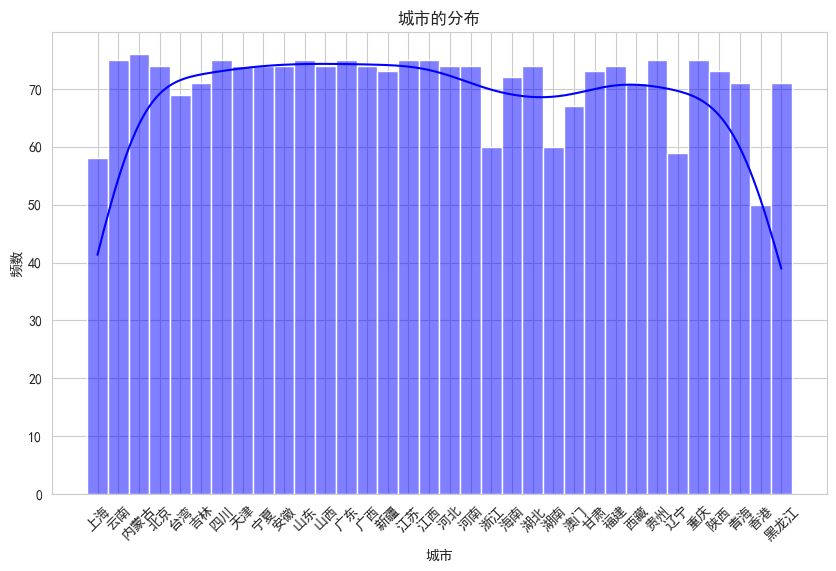

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置 Seaborn 样式
sns.set_style("whitegrid")

# 绘制城市分布的直方图
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.figure(figsize=(10, 6))
sns.histplot(data['城市'], kde=True, color='blue')
plt.title('城市的分布')
plt.xlabel('城市')
plt.ylabel('频数')

# 旋转 x 轴标签
plt.xticks(rotation=45)

plt.show()

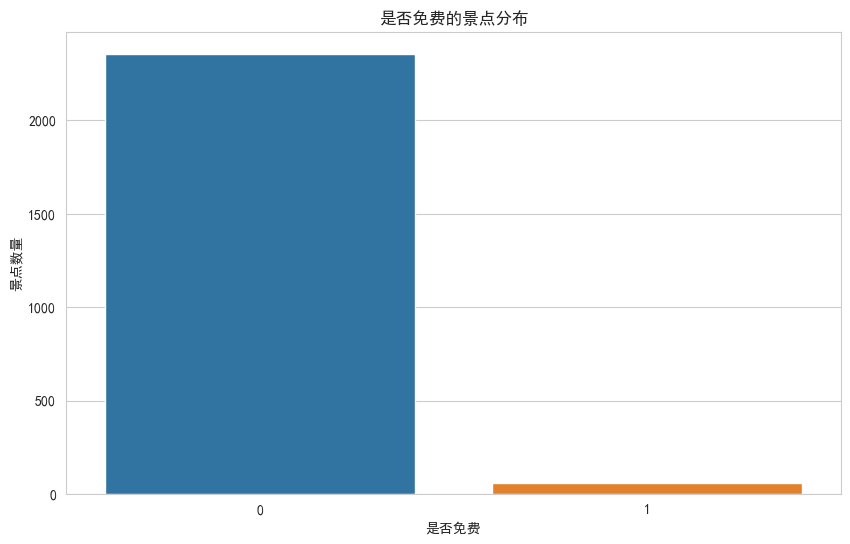

In [19]:
# Plotting the bar chart for '是否免费'
plt.figure(figsize=(10, 6))
sns.countplot(x='是否免费', data = data)
plt.title('是否免费的景点分布')
plt.xlabel('是否免费')
plt.ylabel('景点数量')
plt.show()

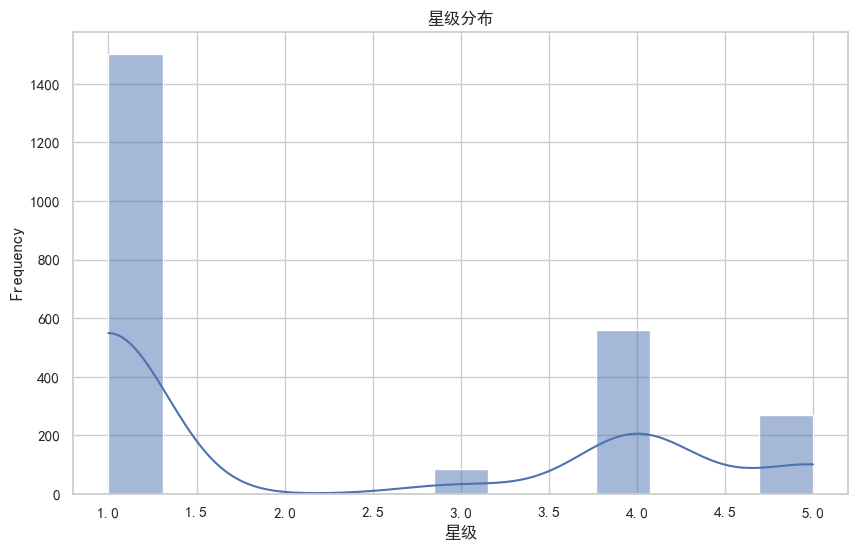

In [20]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Plot 1: Distribution of the number of months of visits (Histogram)
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.figure(figsize=(10, 6))
sns.histplot(data['星级'], kde=True)
plt.title('星级分布')
plt.xlabel('星级')
plt.ylabel('Frequency')
plt.show()

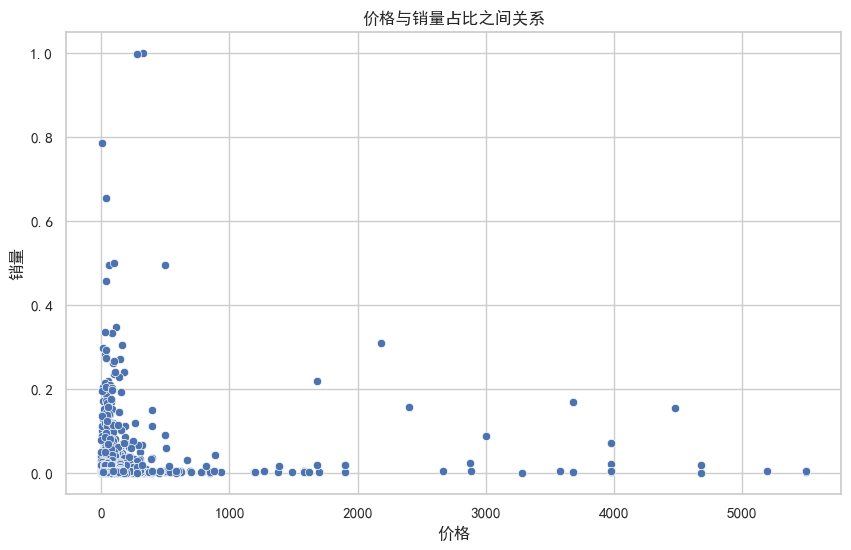

In [21]:
# Plot 2: Relationship between the number of visits and the proportion of personal payment for drugs (Scatter Plot)
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.figure(figsize=(10, 6))
sns.scatterplot(x='价格', y='销量', data=data)
plt.title('价格与销量占比之间关系')
plt.xlabel('价格')
plt.ylabel('销量')
plt.show()

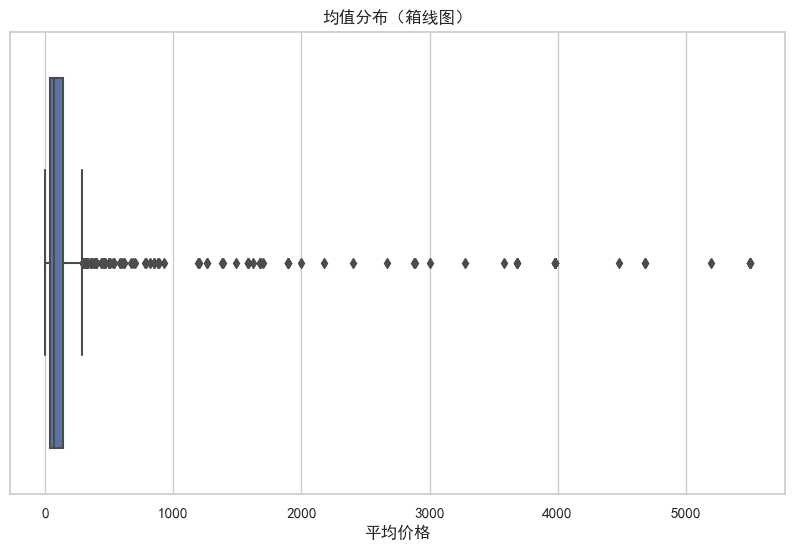

In [22]:
# Plot 3: Distribution of average monthly visit days (Box Plot)
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.figure(figsize=(10, 6))
sns.boxplot(x=data['价格'])
plt.title('均值分布（箱线图）')
plt.xlabel('平均价格')
plt.show()

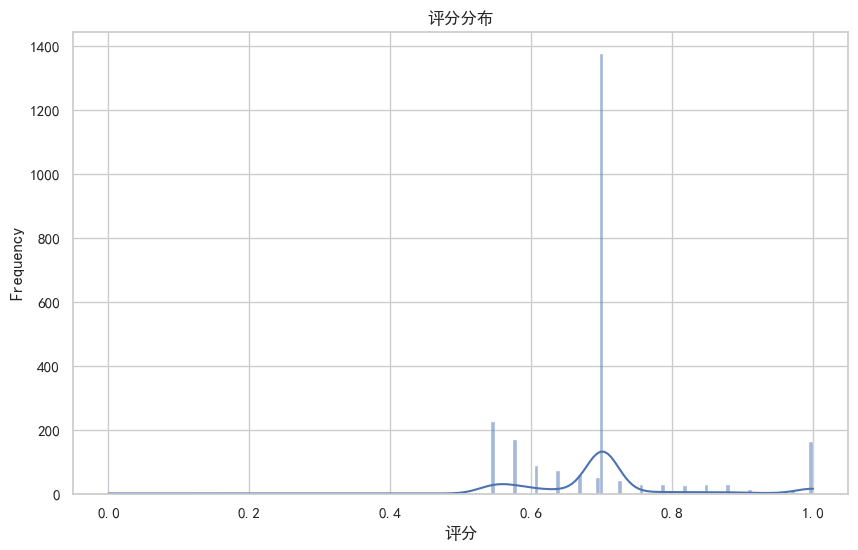

In [23]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Plot 1: Distribution of the number of months of visits (Histogram)
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.figure(figsize=(10, 6))
sns.histplot(data['评分'], kde=True)
plt.title('评分分布')
plt.xlabel('评分')
plt.ylabel('Frequency')
plt.show()

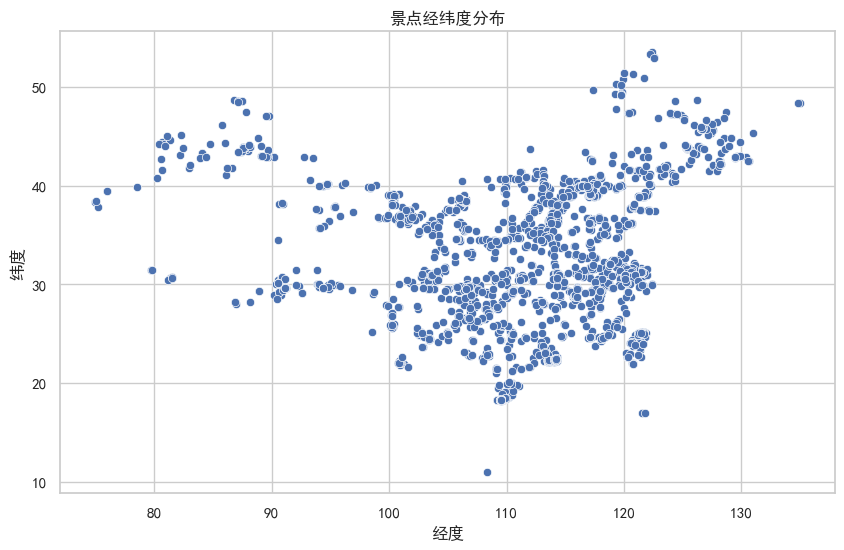

In [24]:
# Plot 2: Relationship between the number of visits and the proportion of personal payment for drugs (Scatter Plot)
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.figure(figsize=(10, 6))
sns.scatterplot(x='经度', y='纬度', data=data)
plt.title('景点经纬度分布')
plt.xlabel('经度')
plt.ylabel('纬度')
plt.show()

## 显示缺失值

In [25]:
missing_values = data.isnull().sum()
summary_statistics = data.describe()

In [26]:
missing_values

编号        0
城市        0
名称        0
星级        0
评分       26
价格        0
销量       26
省/市/区     0
坐标        0
简介       36
是否免费      0
具体地址      1
星级编码     26
经度        0
纬度        0
dtype: int64

In [27]:
summary_statistics

,编号,星级,评分,价格,销量,是否免费,星级编码,经度,纬度
count,2414.000000,2414.000000,2388.000000,2414.000000,2388.000000,2414.000000,2388.000000,2414.000000,2414.000000
mean,1219.417564,2.209611,0.701077,149.335089,0.019652,0.024027,0.303392,112.036483,32.551414
std,704.266408,1.594377,0.107854,436.771313,0.053987,0.153163,0.398963,9.233925,7.196604
min,0.000000,1.000000,0.000000,0.190000,0.000000,0.000000,0.000000,74.957264,10.939046
25%,611.250000,1.000000,0.666721,39.000000,0.002364,0.000000,0.000000,106.853977,27.124111
50%,1218.500000,1.000000,0.701136,70.000000,0.005448,0.000000,0.000000,113.560139,31.306594
75%,1829.750000,4.000000,0.701136,140.000000,0.018400,0.000000,0.750000,118.166841,38.528086
max,2442.000000,5.000000,1.000000,5500.000000,1.000000,1.000000,1.000000,134.960027,53.491943


## XGboost 进行特征重要性分析

In [28]:
import numpy as np

# 特征和目标变量
X = data[['销量','评分', '价格']]  # 特征
y = data['星级']  # 目标变量

# Handling NaN and infinite values by replacing them with 0
X_filled = X.fillna(0).replace([np.inf, -np.inf], 0)

## 使用 Imputer 填充 NaN 值

In [29]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

# 创建 LabelEncoder 对象
label_encoder = LabelEncoder()

# 将非数值类型的列转换为数值类型
X['rating_encoded'] = label_encoder.fit_transform(X['评分'])
X['price_encoded'] = label_encoder.fit_transform(X['价格'])

# 使用 SimpleImputer 填充 NaN 值
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_12168\1781596194.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['rating_encoded'] = label_encoder.fit_transform(X['评分'])
C:\Users\Administrator\AppData\Local\Temp\ipykernel_12168\1781596194.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['price_encoded'] = label_encoder.fit_transform(X['价格'])


In [30]:
from xgboost import XGBClassifier
import pandas as pd

# 特征和目标变量
X = data[['销量','评分', '价格']]  # 特征
y = data['星级']  # 目标变量

# 将星级编码为数字
star_mapping = {1: 0, 3: 1, 4: 2, 5: 3}
y = y.map(star_mapping)

# 创建 XGBoost 分类器对象
xgb_classifier = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# 使用训练集训练模型
xgb_classifier.fit(X, y)

# 获取特征重要性
feature_importances = xgb_classifier.feature_importances_

# 将特征重要性与特征名称配对
features = X.columns
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# 对特征按重要性进行排序
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 显示最重要的前2个特征
print(feature_importance_df.head(3))

  Feature  Importance
2      价格    0.367752
1      评分    0.318640
0      销量    0.313609


## 相关性分析——皮尔逊法

In [31]:
# 计算相关系数矩阵
X = data[['销量','评分', '价格','星级']]  # 特征
correlation_matrix = X.corr()
correlation_matrix

,销量,评分,价格,星级
销量,1.000000,0.106809,0.027148,0.057554
评分,0.106809,1.000000,0.006937,-0.034387
价格,0.027148,0.006937,1.000000,-0.105614
星级,0.057554,-0.034387,-0.105614,1.000000


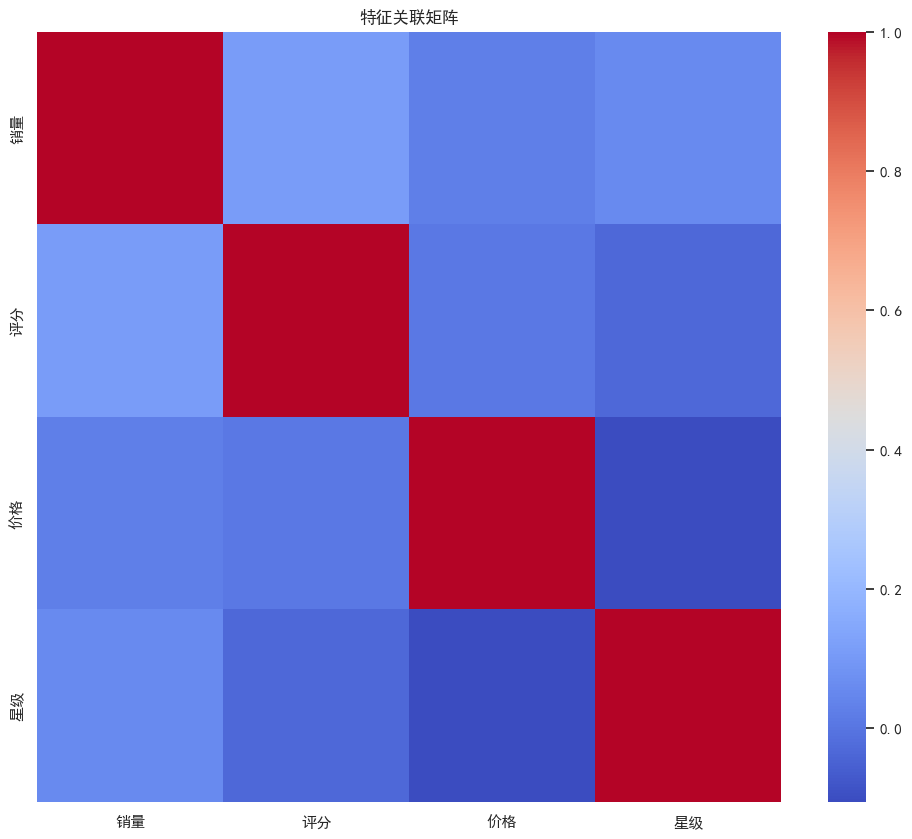

In [32]:
# 可视化相关系数矩阵
import seaborn as sns
import matplotlib.pyplot as plt

# 设置 matplotlib 的字体为黑体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 'SimHei' 是黑体的字体名称
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title('特征关联矩阵')
plt.show()

In [33]:
# 计算相关矩阵
correlation_matrix = X.corr()

# 提取与目标变量'销量'的相关性
correlations_with_target = correlation_matrix['销量'].sort_values(
    ascending=False)

correlations_with_target

销量    1.000000
评分    0.106809
星级    0.057554
价格    0.027148
Name: 销量, dtype: float64

In [34]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import pandas as pd

transactions = X.values.tolist()

# 使用TransactionEncoder转换数据
encoder = TransactionEncoder()
transactions_encoded = encoder.fit(transactions).transform(transactions)
transactions_df = pd.DataFrame(transactions_encoded, columns=encoder.columns_)

# 使用Apriori算法寻找频繁项集
frequent_itemsets = apriori(transactions_df, min_support=0.1, use_colnames=True)

# 使用association_rules寻找关联规则
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)

# 将所有关联规则保存到CSV文件中
rules.to_csv('数据集关联规则.csv', index=False)

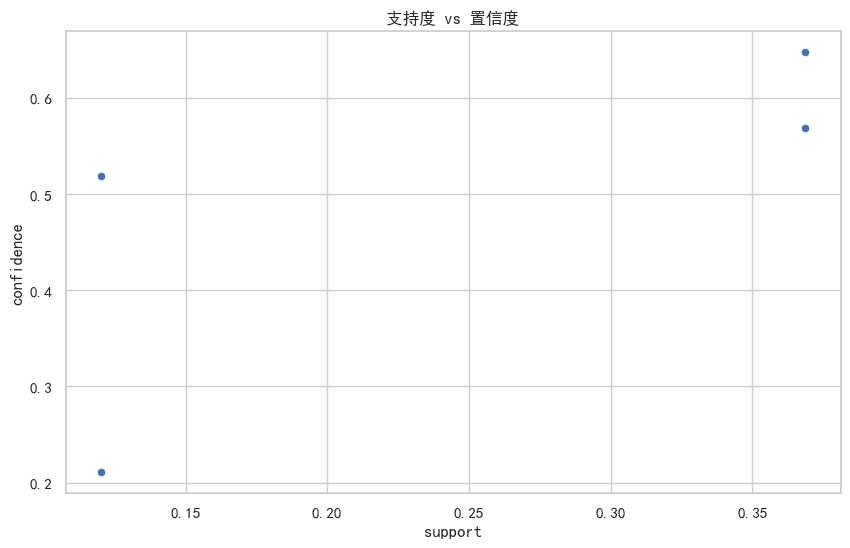

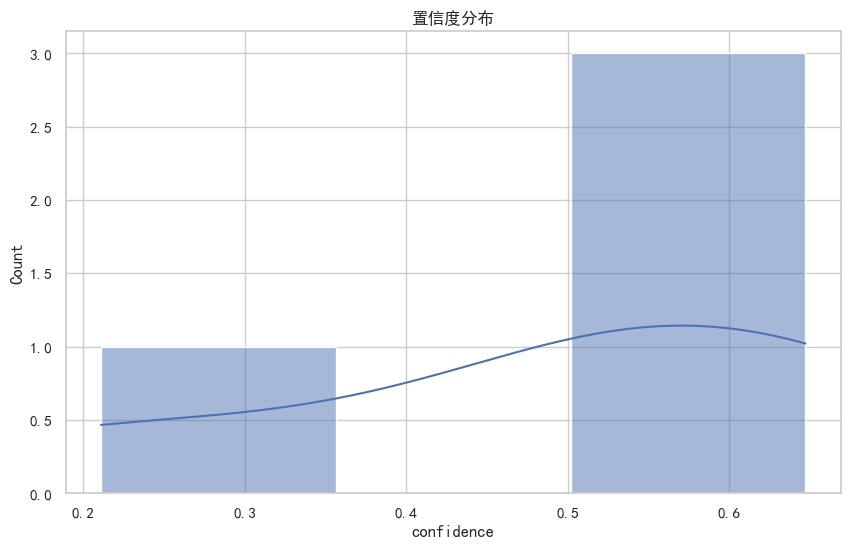

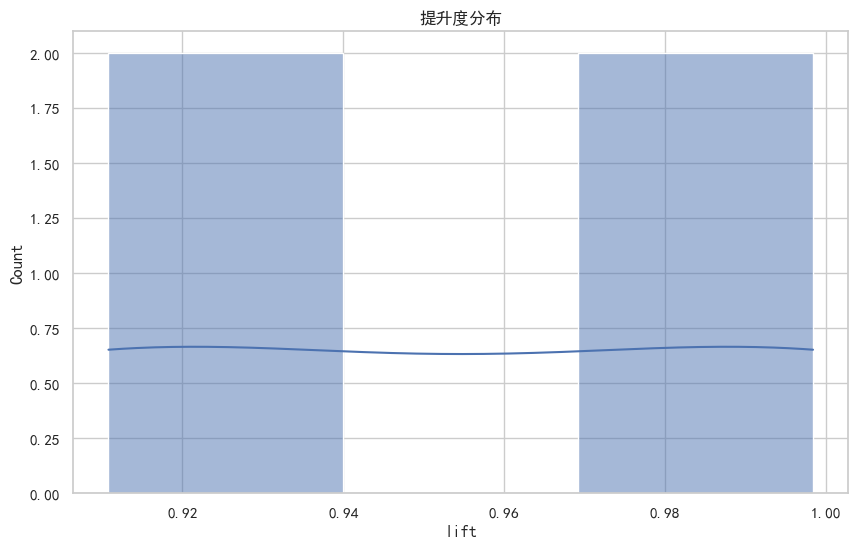

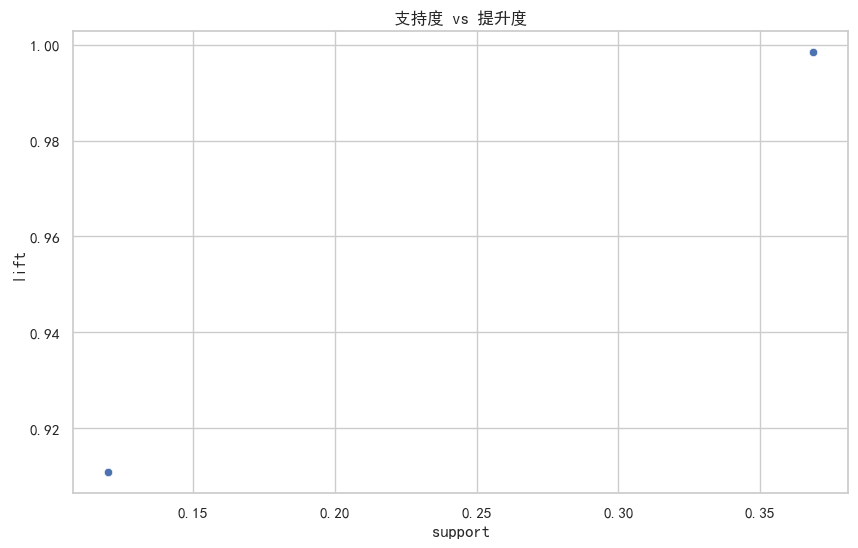

<Figure size 1000x600 with 0 Axes>

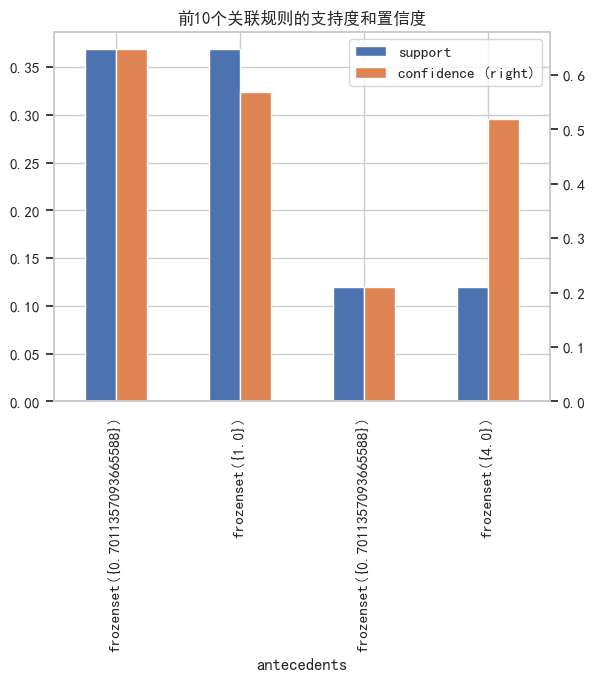

In [35]:
# 设置matplotlib以支持中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号'-'显示为方块的问题

# 读取CSV文件
rules = pd.read_csv('数据集关联规则.csv')

# 绘制支持度 vs 置信度 散点图
plt.figure(figsize=(10, 6))
sns.scatterplot(x='support', y='confidence', data=rules)
plt.title('支持度 vs 置信度')
plt.savefig('支持度_vs_置信度.png')  # 使用中文命名保存文件
plt.show()

# 绘制置信度分布直方图
plt.figure(figsize=(10, 6))
sns.histplot(rules['confidence'], kde=True)
plt.title('置信度分布')
plt.savefig('置信度分布.png')
plt.show()

# 绘制提升度分布直方图
plt.figure(figsize=(10, 6))
sns.histplot(rules['lift'], kde=True)
plt.title('提升度分布')
plt.savefig('提升度分布.png')
plt.show()

# 绘制支持度 vs 提升度 散点图
plt.figure(figsize=(10, 6))
sns.scatterplot(x='support', y='lift', data=rules)
plt.title('支持度 vs 提升度')
plt.savefig('支持度_vs_提升度.png')
plt.show()

# 绘制前10个关联规则的支持度和置信度条形图
# 假设已经按某种方式（如置信度）排序了rules
top_rules = rules.head(10)
plt.figure(figsize=(10, 6))
top_rules.plot(kind='bar',
               x='antecedents',
               y=['support', 'confidence'],
               secondary_y='confidence')
plt.title('前10个关联规则的支持度和置信度')
plt.savefig('前10个关联规则的支持度和置信度.png')
plt.show()

## PCA降维+聚类

D:\Anacoda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


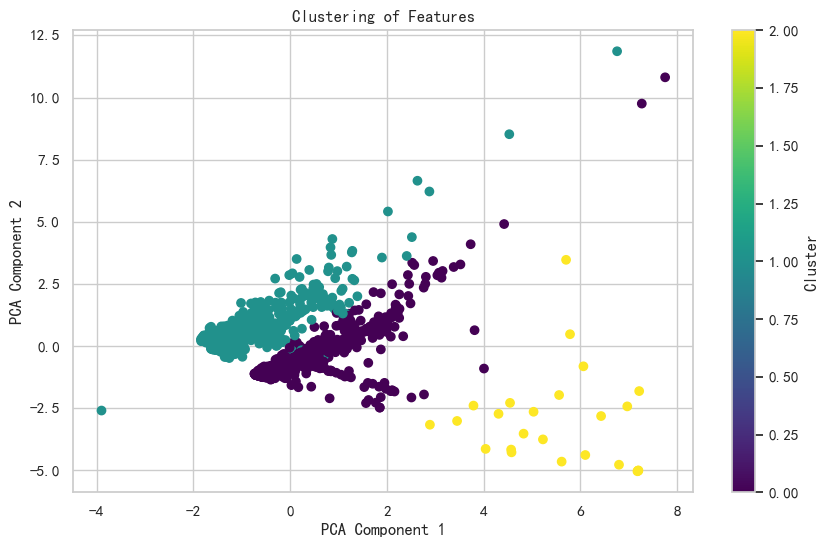

In [36]:
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 填充 NaN 值
imputer = SimpleImputer(strategy='mean')
data_filled = imputer.fit_transform(X)

# 对数据进行标准化
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_filled)

# 聚类
kmeans = KMeans(n_clusters=3)  # 选择聚类的数量
clusters = kmeans.fit_predict(data_scaled)

# 进行 PCA 降维
pca = PCA(n_components=3)  # 选择降维后的维度，这里选择 3 维
data_pca = pca.fit_transform(data_scaled)

# 可视化聚类结果
plt.figure(figsize=(10, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=clusters, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clustering of Features')
plt.colorbar(label='Cluster')
plt.show()

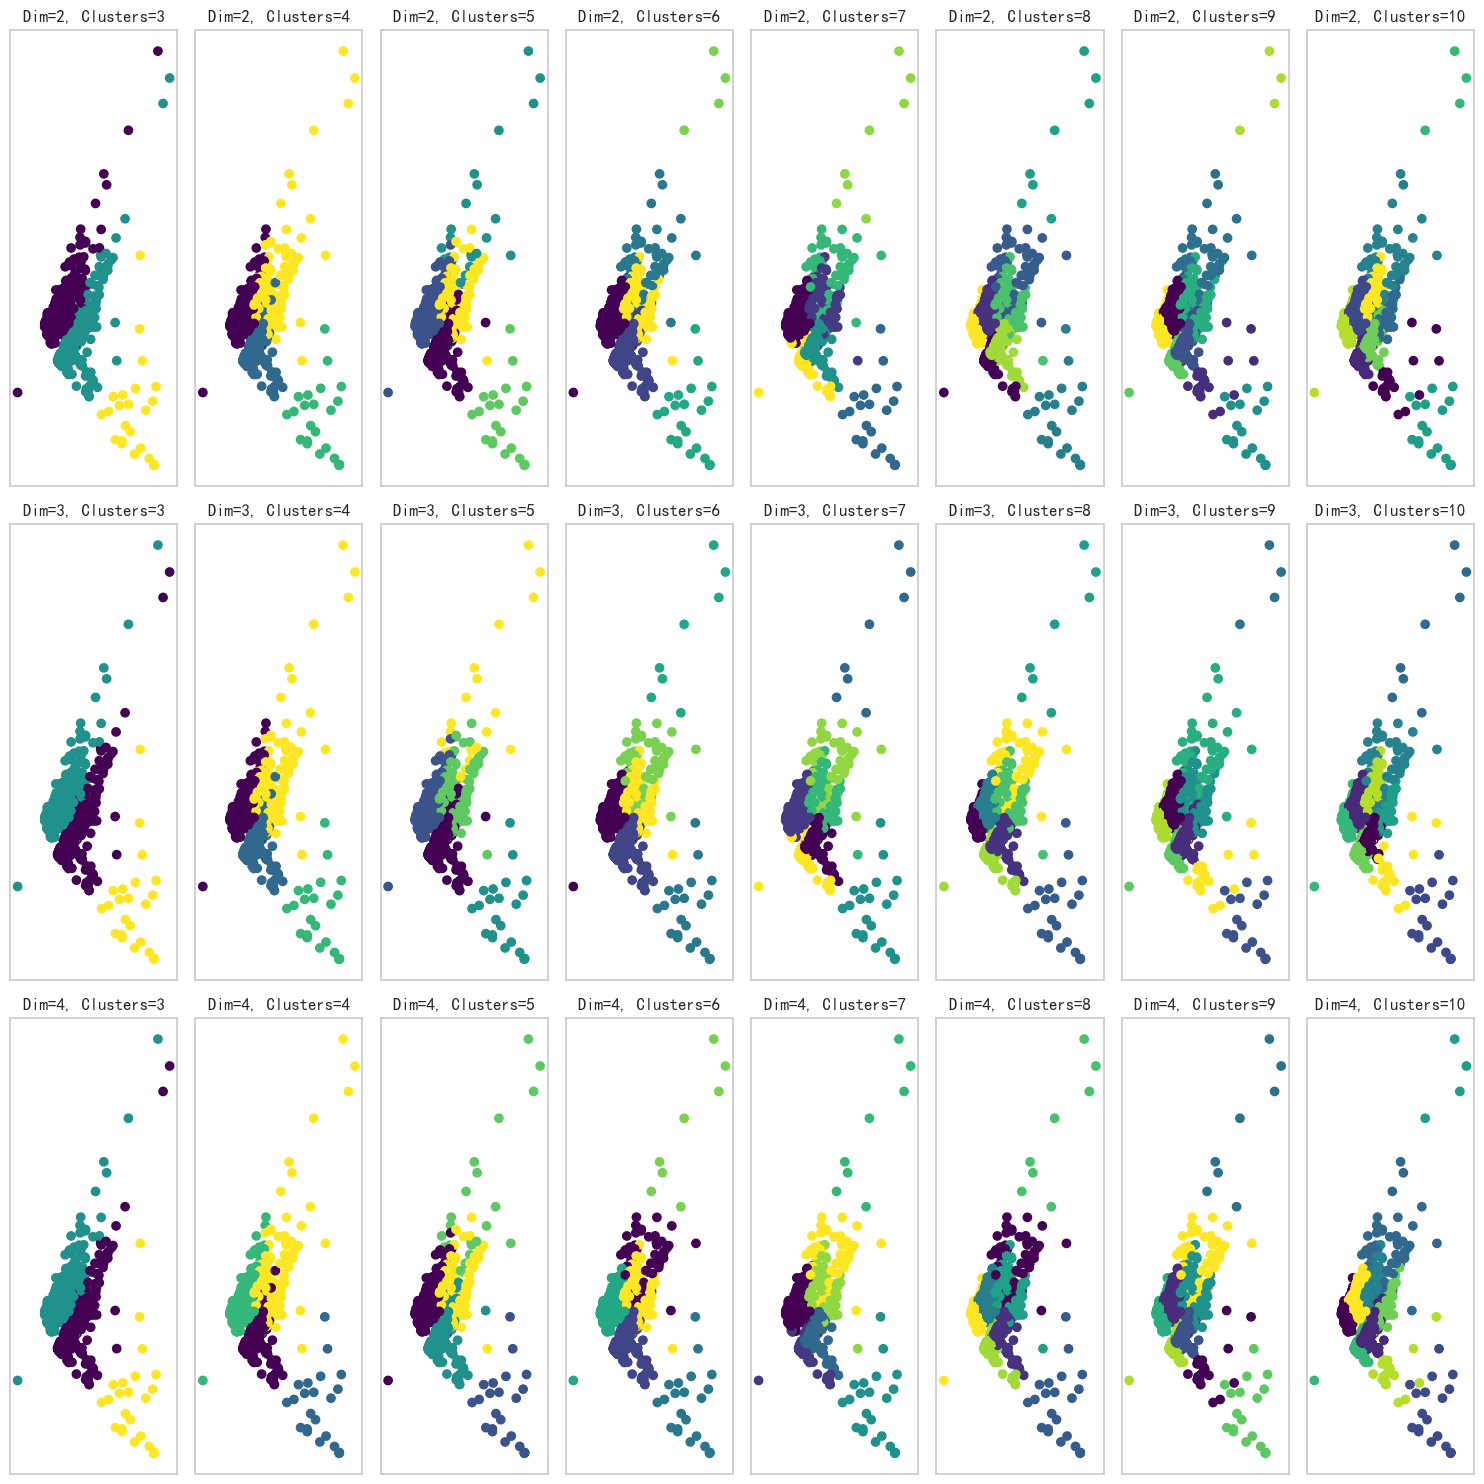

In [37]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 删除NaN的数据项
data_cleaned = X.dropna()

# 标准化数据
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_cleaned)

# 尝试不同的降维维度和聚类数量
dimensions = [2, 3, 4]  # 选择合适的降维维度，根据数据情况调整
clusters_range = [3, 4, 5, 6, 7, 8, 9, 10]

fig, axes = plt.subplots(len(dimensions),
                         len(clusters_range),
                         figsize=(15, 15))

for i, dim in enumerate(dimensions):
    for j, cluster_count in enumerate(clusters_range):
        # 降维
        pca = PCA(n_components=dim)
        data_pca = pca.fit_transform(data_scaled)

        # 聚类
        kmeans = KMeans(n_clusters=cluster_count, n_init=10)  # 显式设置 n_init 参数
        clusters = kmeans.fit_predict(data_scaled)

        # 可视化聚类结果
        axes[i, j].scatter(data_pca[:, 0],
                           data_pca[:, 1],
                           c=clusters,
                           cmap='viridis')
        axes[i, j].set_title(f'Dim={dim}, Clusters={cluster_count}')
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

plt.tight_layout()
plt.show()

D:\Anacoda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anacoda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anacoda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anacoda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._

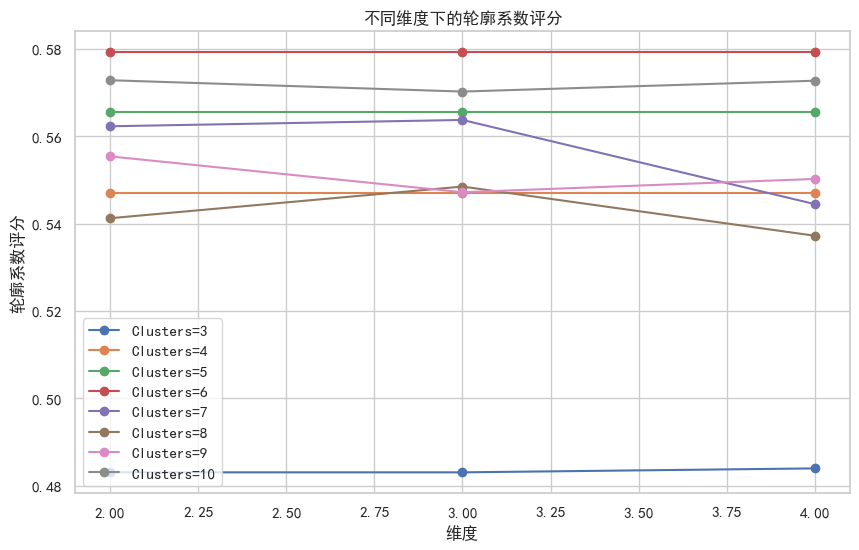

In [38]:
import numpy as np
from sklearn.metrics import silhouette_score

# 删除NaN的数据项
data_cleaned = X.dropna()

# 标准化数据
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_cleaned)

# 尝试不同的降维维度和聚类数量
dimensions = [2,3,4]
clusters_range = [3, 4, 5, 6, 7, 8, 9, 10]

silhouette_scores = []

for dim in dimensions:
    for cluster_count in clusters_range:
        # 降维
        pca = PCA(n_components=dim)
        data_pca = pca.fit_transform(data_scaled)

        # 聚类
        kmeans = KMeans(n_clusters=cluster_count)
        clusters = kmeans.fit_predict(data_scaled)

        # 计算轮廓系数评分
        silhouette_avg = silhouette_score(data_scaled, clusters)
        silhouette_scores.append((dim, cluster_count, silhouette_avg))

# 将结果转换为数组
silhouette_scores = np.array(silhouette_scores)

# 绘制折线图
plt.figure(figsize=(10, 6))
for cluster_count in clusters_range:
    scores_for_cluster_count = silhouette_scores[silhouette_scores[:, 1] ==
                                                 cluster_count]
    plt.plot(scores_for_cluster_count[:, 0],
             scores_for_cluster_count[:, 2],
             marker='o',
             label=f'Clusters={cluster_count}')

plt.title('不同维度下的轮廓系数评分')
plt.xlabel('维度')
plt.ylabel('轮廓系数评分')
plt.legend()
plt.grid(True)
plt.show()